# EP2
## Cálculo do Conjunto de Mandelbrot em Paralelo com OMPI e CUDA

Nesse EP temos apenas quatro membros pois um trancou a materia:

| Nome | NUSP |
|------|------|
| Daniel Hotta | 9922700 |
| Matheus Laurentys | 9793714 |
| Pedro Gigeck | 10737136 |
| Rafael Gonçalves | 9009600 |


## Configuração do Ambiente

O ambiente será herdado do EP1

In [2]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
    Fetching: [========================================>]  99.9 %    Fetching: [========================================>]  100.0 % Resolving package versions...
 Installed ZeroMQ_jll ── v4.3.2+4
 Installed MbedTLS_jll ─ v2.16.6+0
 Installed Parsers ───── v1.0.6
 Installed ZMQ ───────── v1.2.1
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [c8ffd9c3] ↑ MbedTLS_jll v2.16.0+2 ⇒ v2.16.6+0
  [69de0a69] ↑ Parsers v1.0.2 ⇒ v1.0.6
  [c2297ded] ↑ ZMQ v1.2.0 ⇒ v1.2.1
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+2 ⇒ v4.3.2+4


In [3]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [7073ff75] IJulia v1.21.2


## Sobre as Implementações

As implementações com pthreads, OMP e sequencial foram mantidas iguais ao EP1. Estão, respectivamente, em  `mandelbrot_pth.c`, `mandelbrot_omp.c` e `mandelbrot_seq.c`.

A implementação com OMPI está em `mandelbrot_ompi.c`.

A implementação com CUDA está em  `mandelbrot_cuda.cu`.

A implementação bônus MPI + OMP está em `mandelbrot_ompi_omp.c`

Para compilar todas as implementações, basta rodar o Makefile.

In [3]:
; make

make: Nothing to be done for 'all'.


Podemos rodar qualquer uma das implementações para observar as imagens. Os arquivos executáveis estarão no diretório `bin`

In [ ]:
; ./bin/mandelbrot_cuda -2.5 1.5 -2.0 2.0 11500 900 1024

Na versão OMPI, o número de tasks é passado como parâmetro pelo mpirun, se não for passado, o mpirun definirá um valor default.

Na versão CUDA, possibilitamos a execução com grids e blocos uni e bidimensionais. 

Para executar com uma dimensão, passe 8 argumentos na linha de comando, sendo os dois últimos os números de blocos e threads por bloco.

Para rodar com grids e blocos bidimensionais, passe 10 argumentos na linha de comando, sendo os 4 últimos as dimensões (x, y) do grid e blocos.

Na versão OMPI + OMP, o número de threads por task é o último argumento na linha de comando. Se não for passado, o OMP definirá como defaul uma thread por core. 

De qualquer forma, as instruções sobre os argumentos da linha de comando são disparadas no console, caso não esteja compatível.


## Determinação Experimental dos Parâmetros

Conforme especificado no enunciado, todas as medições foram feitas com 15 repetições, com o tamanho da imagem 4096 para a região Triple Spiral Valley.

Para medir os tempo de execução, usamos o script `run_measurements.sh`, com o comando `perf`, similar ao EP1.

Todos os resultados já estão na pasta results. O script leva algumas horas e não precisa ser rodado novamente.

In [ ]:
#; ./run_measurements.sh

### CUDA

Para a versão CUDA, os valores experimentados para o grid foram as seguintes combinações:

`Blocos no grid = (1, 512, 1024, 2048)`

`Threads por bloco = (4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048)`

Podemos conferir os resultados nos gráficos gerados abaixo.

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `/mnt/c/Users/gigec/OneDrive/Área de Trabalho/Pedro/BCC/MAC0219 Paralela/mac-0219/EP2/Project.toml`
 [no changes]
   Updating `/mnt/c/Users/gigec/OneDrive/Área de Trabalho/Pedro/BCC/MAC0219 Paralela/mac-0219/EP2/Manifest.toml`
 [no changes]


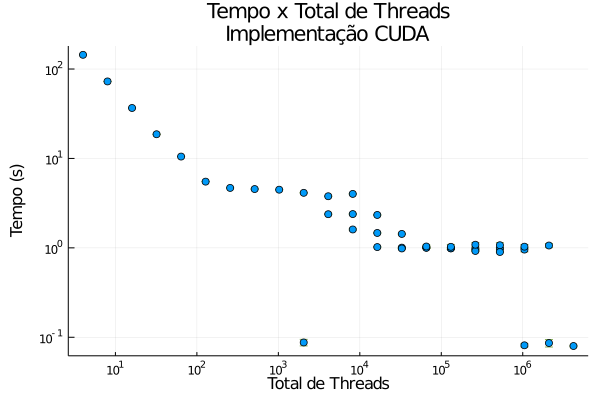

In [2]:
import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# DataFrame to concat all data to write in csv
df_csv = DataFrame()

# ---------- Getting CUDA results ----------

# GPU grid dimensions
cuda_blocks = [1, 512, 1024, 2048]
cuda_threads = [2 ^ x for x in 2:11]

# Get the time values from the log file and saves in a string
function get_log_string(implementation, arg)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/$implementation/triple_spiral_$arg.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log file and saves in a string
function get_log_deviation(implementation, arg)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/$implementation/triple_spiral_$arg.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Create a dataframe with values from the log files for all grid sizes
function get_data_frame()
    df = DataFrame()
    sz = []
    times = []
    error = []
    for bl in cuda_blocks
        for th in cuda_threads
            dim = string(bl, "_", th)
            s = get_log_string("cuda", dim)
            d = get_log_deviation("cuda", dim)
            
            t = parse(Float64, s)
            dv = parse(Float64, chop(d, tail = 2))
            dv = t*dv/100
            
            push!(times, t)
            push!(error, dv)
            push!(sz, bl * th)
        end
    end
    
    df[!, "sz"] = sz
    df[!, "times"] = times
    df[!, "dv"] = error
    df_csv[!, "cuda.sz"] = sz
    df_csv[!, "cuda.times"] = times
    df_csv[!, "cuda.DP"] = error
    return df
end

function plot_data_frame(df)
    xs = df.sz
    ys = df.times
    deviation = df.dv
    scatter(xs, ys, yerror = deviation, label = "", xscale = :log10, yscale = :log10,
            xlabel = "Total de Threads", ylabel = "Tempo (s)", 
            title = "Tempo x Total de Threads\nImplementação CUDA\n")
end

function plot_heatmap(df)
    data = convert(Array{Float64,1},df.times)
    data = reshape(data, 4, 10)
    heatmap(string.(cuda_threads),
            string.(cuda_blocks),
            data, colorbar_title = "tempo (s)", color = :viridis,
            xlabel="número de threads", ylabel="número de blocos", clims = (0, 10),
            title="Tempo(s) x (Threads x Blocos)")
end
            
df = get_data_frame()
plot_data_frame(df)

df.

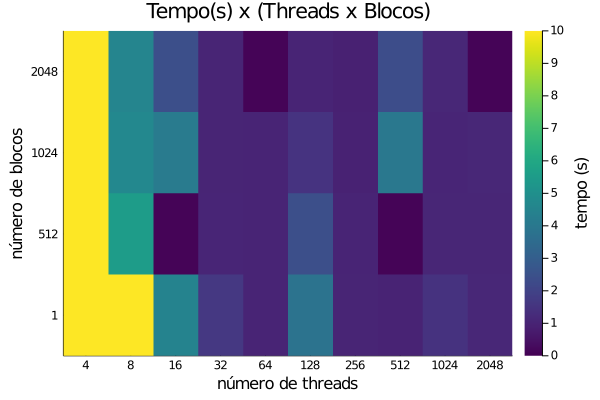

In [3]:
plot_heatmap(df)

O primeiro ponto a ser notado é a estabilidade das execuções. No código, podemos conferir que o desvio padrão das medições está sendo mostrado, porém ele é menor que o ponto na representação gráfica. Nos experimentos, conferimos que o desvio padrão não passa de 1 segundo em nenhuma execução.

Outro resultado é que, em geral, o tempo de execução é inversamente proporcional ao número total de threads. Quanto mais threads, mais rápido. Observamos isso na tendência de queda do primeiro gráfico (que está em escala logarítmica). Com outras implementações paralelas, observávamos um número de threads que minimizava o tempo de execução e quando executado com mais threads, o tempo aumentava.

A principal explicação para esse fenômeno está no hardware. O potencial de computação paralela de uma GPU, que pode executar milhares de threads simultaneamente, não é comparável com o potencial de uma CPU com 4 ou 8 núcleos.

Além disso, sabemos que a distribuição dos blocos nos grids não influenciam bruscamente no tempo de execução. O que importa é o número total de blocos e o número de threads por bloco.
No segundo gráfico, vemos que existem configarações que beneficiam o desempenho. Como o caso de 512 blocos com 16 threads, que teve um desempenho quase 10 vezes melhor que outras combinações com o mesmo númeor total de threads. 

Com isso, concluímos que os melhores parâmetros para execução do experimento são aqueles que maximizam o total de threads, que é capacidade máxima da GPU, no nosso caso, **2048 blocos com 2048 threads**.

### OMPI

Para a implementação com OMPI, usamos as quantidades de processos 4, 8, 16, 32 e 64, conforme sugerido no enunciado.

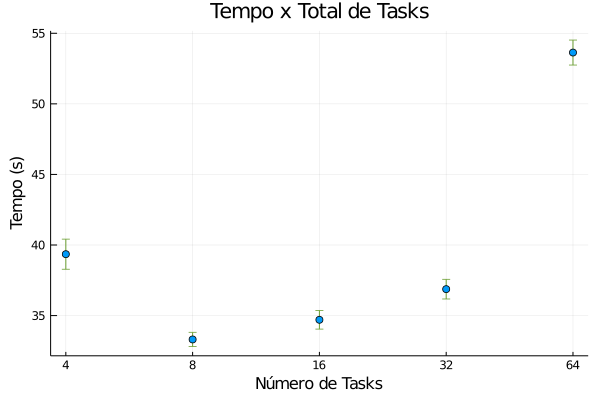

In [4]:

# ---------- Getting OMPI results ----------

# Number of tasks OMPI
ompi_tasks = [2 ^ x for x in 2:6]

# Create a dataframe with values from the log files
function get_data_frame()
    df = DataFrame()
    sz = []
    times = []
    error = []
    for i in ompi_tasks
        s = get_log_string("ompi", i)
        d = get_log_deviation("ompi", i)
        s = replace(s, ','=>'.')
        d = replace(d, ','=>'.')
        t  = parse(Float64, s)
        dv = parse(Float64, chop(d, tail = 2))
        dv = t * dv / 100
            
        push!(times, t)
        push!(error, dv)
        push!(sz, string(i))
    end
    
    df[!, "sz"] = sz
    df[!, "times"] = times
    df[!, "dv"] = error
    return df
end

function plot_data_frame(df)
    xs = df.sz
    ys = df.times
    deviation = df.dv
    plot(xs, ys, seriestype = :scatter, yerror = deviation, label = "", xlabel = "Número de Tasks", 
         ylabel = "Tempo (s)", title = "Tempo x Total de Tasks\n")
end
            
# Plot (time x total_tasks) graph
df = get_data_frame()
plot_data_frame(df)


Observa-se que temos o menor tempo de execução para o ponto com 8 processos sendo executados, sendo que esse tempo aumenta conforme acrescentamos mais processos ao calculo da imagem.

Além disso, temos dois pontos estranhos a serem considerados, sendo eles referentes ao calculo realizado usando 4 e 64 processos, que apresentam um tempo de execução significativamente maior que outros pontos observados, o que vai contra a intuição anterior que, conforme o numero de processos aumentaria mais rápido seria o nosso tempo de execução para o calculo da região já informada.

Porém, devemos considerar que o MPI é uma ferramenta para execução distribuída dos processos e não na mesma máquina, por isso podemos observar irregularidades como essa.

### OMPI + OMP

Para a implementação bônus de OMPI com OMP, testamos com o mesmo número de processos que a OMP e o mesmo número de threads que usado no EP1 para OMP.

`número de processos = (4, 8, 16, 32, 64)`

`número de threads = (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048)`

Embora já tenhamos resultados isolados sobre as duas técnicas, vamos conferir se a combinação de ambas mantém o desempenho dos parâmetros conforme esperado: 

In [15]:
# ---------- Getting OMPI + OMP results ----------

ompi_tasks  = [2 ^ x for x in 2:4]
omp_threads = [2 ^ x for x in 1:5]

# Create a dataframe with values from the log
function get_data_frame()
    df = DataFrame()
    sz = []
    times = []
    error = []
    for i in ompi_tasks
        for th in omp_threads
            dim = string(i, "_", th)
            s = get_log_string("omp+ompi", dim)
            d = get_log_deviation("omp+ompi", dim)
            
            t  = parse(Float64, chop(s, tail = 1))
            dv = parse(Float64, chop(d, tail = 2))
            dv = t * dv / 100
            
            push!(times, t)
            push!(error, dv)
            push!(sz, string())
        end
    end
    
    df[!, "sz"] = sz
    df[!, "times"] = times
    df[!, "dv"] = error
    return df
end

function plot_heatmap(df)
    data = convert(Array{Float64,1},df.times)
    data = reshape(data, 4, 10)
    heatmap(string.(omp_threads),
            string.(ompi_tasks),
            data, colorbar_title = "tempo (s)", color = :viridis,
            xlabel="número de threads", ylabel="número de processos", clims = (0, 20),
            title="Tempo(s) x (Threads x Blocos)")
end
            
    
# Plot (time x total_tasks) graph 
df = get_data_frame()
plot_data_frame("df")

ErrorException: type String has no field sz

-------- Conclusões sobre OMPI + OMP

## Comparando Implementações

Relembrando quais foram os melhores parâmetros obtidos para cada implementação:

| Implementação  | Threads      | Outro Parâmetro |
| :------------- | :----------: | --------------: |
| Pthreads       | 32 threads   |                 |
| OMP            | 32 threads   |                 |
| CUDA           | 2048 threads | 2048 blocos     |
| OMPI           |              | 8 processos     |
| OMPI + OMP     | x threads    | x processos     |


Comparando as implementações com esses parâmetros: 

*(os dados de pthreads e OMP foram copiados dos results do EP1)*

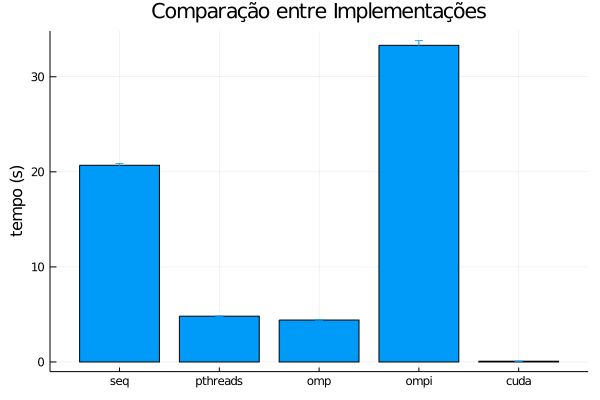

In [12]:
# ---------- Plotting graph for all versions ----------

# Each version with best parameters
implementations = [["seq", ""],
                   ["pthreads", "32"],
                   ["omp", "32"],  
                   ["ompi", "8"],
                   ["cuda", "2048_2048"]]
                   #["ompi_omp", "x_y"]]

function get_comparison_dataframe()
    df = DataFrame()
    names = []
    times = []
    error = []
    for i in implementations
        s = get_log_string(i[1], i[2])
        d = get_log_deviation(i[1], i[2])
        s = replace(s, ','=>'.')
        d = replace(d, ','=>'.')
        
        t = parse(Float64, s)
        dv = parse(Float64, chop(d, tail = 2))
        dv = t*dv/100

        push!(times, t)
        push!(error, dv)
        push!(names, i[1])
    end
    
    df[!, "names"] = names
    df[!, "times"] = times
    df[!, "dv"] = error
    
    return df
end

function plot_comparison(df)
    bar(df.names, df.times, yerror = df.dv, label = "",
        ylabel = "tempo (s)", title = "Comparação entre Implementações")
end
 
df = get_comparison_dataframe()
plot_comparison(df)

# Daqui pra baixo eu não mexi ------------------------------------------------------------

Com esse gráfico final, dois fenômenos principais chamam a atenção: a eficiência de CUDA e a ineficiência do OMPI.

A eficiência de cuda, como já observado, se deve a arquitetura do hardware da GPU, que tem um potêncial de paralelização muito maior que a CPU. E, como a tarefa de calcular o conjunto de Mandelbrot é trivialmente paralelizável, essa implementação leva muita vantagem sobre as outras.

A desvantagem do OMPI atribuímos a dois fatores. O primeiro é a passagem de mensagens. Diferentemente das outras implementações, não temos fácil acesso à uma memória compartilhada por todos os workers, então compartilhar os resultados obtidos paralelamente tem um custo elevado. Outro ponto é que os experimentos foram realizados em uma única máquina, enquanto o ompi pode rodar idealmente em vários dispositivos separados.